## Опис тесту

Монетизаційний A/B тест у мобільному застосунку з моделлю підписок. Тестуємо, чи тижнева підписка генерує більше revenue порівняно з місячною.

**Control** — місячна підписка за 5.99 доларів з триденним пробним періодом

**Treatment** — тижнева підписка за 2.99 доларів з триденним пробним періодом

Тест тривав тиждень на Tier-1 ринках: AU, CA, GB, US.

## Опис стовпців

- **user_id** — ідентифікатор користувача
- **install_date** — дата інсталу
- **test_group** — група, в яку користувач потрапив в A/B тесті
- **country** — код країни користувача
- **trial** — чи оформив користувач пробний період
- **paid** — чи здійснив користувач покупку після пробного періоду
- **subscription_name** — назва підписки, якщо користувач оформив пробний період
- **revenue_1m** — ревеню, яке приніс користувач протягом першого місяця з моменту закінчення пробного періоду

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('KMA TestTask Product Analyst - Task1.csv')

# Data overview
print("Dataset shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (15285, 8)

Column types:
user_id               object
install_date          object
country               object
test_group            object
trial                  int64
paid                   int64
subscription_name     object
revenue_1m           float64
dtype: object

Missing values:
user_id                  0
install_date             0
country                  0
test_group               0
trial                    0
paid                     0
subscription_name    13562
revenue_1m               0
dtype: int64


In [4]:
df.head(10)

,user_id,install_date,country,test_group,trial,paid,subscription_name,revenue_1m
0,0000dd3fa4702a63d1b76aaffe1ab39b,2023-06-05,US,treatment,0,0,NaN,0.0
1,0001f27ab7e22228e54c8b2028b43f24,2023-06-07,AU,treatment,0,0,NaN,0.0
2,0006c5c547801308b36ea3cf669856ae,2023-06-07,AU,treatment,0,0,NaN,0.0
3,000d1a300263c5db91cbefa3852898a7,2023-06-07,AU,control,0,0,NaN,0.0
4,000e5e62e8746e467ed9f49ac5de3208,2023-06-06,US,treatment,0,0,NaN,0.0
5,000e65027879059fe2a814be4ff21316,2023-06-04,CA,treatment,0,0,NaN,0.0
6,000eb23cf1caf152d9b8d4ec2441e085,2023-06-02,AU,control,0,0,NaN,0.0
7,0013a6c091188301710271b8195a999a,2023-06-03,GB,treatment,0,0,NaN,0.0
8,001f99c190cb677eadbbe144a5c7eb02,2023-06-01,CA,treatment,0,0,NaN,0.0
9,002066ee39aacf3dbe4294be1a08bd77,2023-06-06,GB,control,0,0,NaN,0.0


In [5]:
# Duplicates check
total_users = len(df)
unique_users = df['user_id'].nunique()
print(f"Total rows: {total_users:,}, Unique user_ids: {unique_users:,}, Duplicates: {total_users - unique_users}")

# Data range
df['install_date'] = pd.to_datetime(df['install_date'])
print(f"\nDate range: {df['install_date'].min().date()} to {df['install_date'].max().date()}")
print(df['install_date'].value_counts().sort_index())

# test_group
print(f"\ntest_group values:\n{df['test_group'].value_counts()}")

# country
print(f"\ncountry values:\n{df['country'].value_counts()}")

# trial values
print(f"\ntrial values:\n{df['trial'].value_counts()}")

# paid values
print(f"\npaid values:\n{df['paid'].value_counts()}")

# subscription_name
print(f"\nsubscription_name distribution:\n{df['subscription_name'].value_counts(dropna=False)}")

Total rows: 15,285, Unique user_ids: 15,285, Duplicates: 0

Date range: 2023-06-01 to 2023-06-07
install_date
2023-06-01    2428
2023-06-02    1917
2023-06-03    1898
2023-06-04    2090
2023-06-05    2472
2023-06-06    2247
2023-06-07    2233
Name: count, dtype: int64

test_group values:
test_group
treatment    7658
control      7627
Name: count, dtype: int64

country values:
country
CA    3895
GB    3837
US    3790
AU    3763
Name: count, dtype: int64

trial values:
trial
0    13562
1     1723
Name: count, dtype: int64

paid values:
paid
0    15020
1      265
Name: count, dtype: int64

subscription_name distribution:
subscription_name
NaN                      13562
monthly.5.99.3d.trial      925
weekly.2.99.3d.trial       798
Name: count, dtype: int64


In [6]:
# User distribution control/treatment
group_dist = df['test_group'].value_counts(normalize=True) * 100
print(f"\nTest group distribution:\n{group_dist}")

# Country distribution by test group
country_by_group = pd.crosstab(df['test_group'], df['country'], normalize='index') * 100
print(f"\nCountry distribution by test group (%):\n{country_by_group.round(2)}")

# Chi-square test for country distribution
contingency_country = pd.crosstab(df['test_group'], df['country'])
chi2, p_value, dof, expected = chi2_contingency(contingency_country)
print(f"\nChi-square test for country distribution: p-value = {p_value:.4f}")

# Daily distribution by test group
date_by_group = pd.crosstab(df['install_date'], df['test_group'])
date_dist = date_by_group.div(date_by_group.sum(axis=1), axis=0) * 100
print(f"\nDaily distribution by test group (%):\n{date_dist.round(2)}")


Test group distribution:
test_group
treatment    50.101407
control      49.898593
Name: proportion, dtype: float64

Country distribution by test group (%):
country        AU     CA    GB     US
test_group                           
control     25.28  25.38  24.2  25.13
treatment   23.96  25.58  26.0  24.46

Chi-square test for country distribution: p-value = 0.0391

Daily distribution by test group (%):
test_group    control  treatment
install_date                    
2023-06-01      49.14      50.86
2023-06-02      48.72      51.28
2023-06-03      49.32      50.68
2023-06-04      49.43      50.57
2023-06-05      50.32      49.68
2023-06-06      51.85      48.15
2023-06-07      50.25      49.75


З даних вище, можемо побачити, що для тестування брали вибірку завантажень за 7 днів, вибірки розподілені рівномірно по групах, країнах та днях. Серед 15285 учасників тесту 1723 оформили пробну підписку, з яких 265 оплатили підписку після пробного періоду.

In [19]:
# Sample size & distribution
sample_size = df.groupby('test_group').size()
total = len(df)

print(f"Total users: {total:,}")
print(f"\nSample size by group:")
for group, size in sample_size.items():
    pct = size / total * 100
    print(f"  {group}: {size:,} ({pct:.1f}%)")

# Statistical power & MDE for key metrics
from scipy.stats import norm

def calc_mde(baseline, n, alpha=0.05, power=0.80):
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    se = np.sqrt(2 * baseline * (1 - baseline) / n)
    mde_abs = (z_alpha + z_beta) * se
    mde_rel = mde_abs / baseline * 100
    return mde_abs, mde_rel

n_per_group = sample_size.min()
n_trial = df[df['trial'] == 1].groupby('test_group').size().min()

# Actual effects from data
ctrl = df[df['test_group'] == 'control']
treat = df[df['test_group'] == 'treatment']

trial_lift = abs(treat['trial'].mean() - ctrl['trial'].mean()) / ctrl['trial'].mean() * 100
paid_lift = abs(treat['paid'].mean() - ctrl['paid'].mean()) / ctrl['paid'].mean() * 100
t2p_lift = abs(treat[treat['trial']==1]['paid'].mean() - ctrl[ctrl['trial']==1]['paid'].mean()) / ctrl[ctrl['trial']==1]['paid'].mean() * 100

metrics = [
    ('Trial Rate',    df['trial'].mean(), n_per_group, trial_lift),
    ('Paid Rate',     df['paid'].mean(),  n_per_group, paid_lift),
    ('Trial-to-Paid', df[df['trial']==1]['paid'].mean(), n_trial, t2p_lift),
]

print(f"\nMinimum Detectable Effect (α=0.05, power=80%):")
print(f"{'Metric':<18} {'Baseline':>10} {'N/group':>10} {'MDE (rel)':>12} {'Actual Effect':>15}")
for name, baseline, n, actual in metrics:
    mde_abs, mde_rel = calc_mde(baseline, n)
    print(f"{name:<18} {baseline:>9.2%} {n:>10,} {mde_rel:>11.1f}% {actual:>14.1f}%")

Total users: 15,285

Sample size by group:
  control: 7,627 (49.9%)
  treatment: 7,658 (50.1%)

Minimum Detectable Effect (α=0.05, power=80%):
Metric               Baseline    N/group    MDE (rel)   Actual Effect
Trial Rate            11.27%      7,627        12.7%           14.1%
Paid Rate              1.73%      7,627        34.2%           27.9%
Trial-to-Paid         15.38%        798        32.9%           48.9%


MDE залежить від того, яку метрику дивимось:
- Trial Rate: MDE = 12% — достатня потужність
- Paid Rate: MDE = 34% — тест ловить лише великі ефекти
- Trial-to-Paid: MDE = 33% — малий sample обмежує чутливість

Це пояснює, чому trial rate (ефект 14%) і trial-to-paid (49%) показали значущість, а paid rate ні.

In [8]:
# Conversion funnel metrics

# Trial Rate
trial_metrics = df.groupby('test_group')['trial'].agg(['sum', 'mean', 'count'])
trial_metrics.columns = ['trial_users', 'trial_rate', 'total_users']

control_trial_rate = trial_metrics.loc['control', 'trial_rate']
treatment_trial_rate = trial_metrics.loc['treatment', 'trial_rate']
trial_abs_diff = treatment_trial_rate - control_trial_rate
trial_rel_diff = (trial_abs_diff / control_trial_rate) * 100

print("Trial Rate (Install -> Trial)")
print(trial_metrics)
print(f"\nAbsolute difference: {trial_abs_diff:.4f} ({trial_abs_diff*100:.2f}%)")
print(f"Relative lift: {trial_rel_diff:+.2f}%")

# Paid Rate
paid_metrics = df.groupby('test_group')['paid'].agg(['sum', 'mean'])
paid_metrics.columns = ['paid_users', 'paid_rate']

control_paid_rate = paid_metrics.loc['control', 'paid_rate']
treatment_paid_rate = paid_metrics.loc['treatment', 'paid_rate']
paid_abs_diff = treatment_paid_rate - control_paid_rate
paid_rel_diff = (paid_abs_diff / control_paid_rate) * 100

print("\n\nPaid Rate (Install -> Paid)")
print(paid_metrics)
print(f"\nAbsolute difference: {paid_abs_diff:.4f} ({paid_abs_diff*100:.2f}%)")
print(f"Relative lift: {paid_rel_diff:+.2f}%")

# Trial-to-Paid Conversion
trial_users = df[df['trial'] == 1]
t2p_metrics = trial_users.groupby('test_group')['paid'].agg(['sum', 'mean', 'count'])
t2p_metrics.columns = ['paid_from_trial', 'trial_to_paid_rate', 'trial_users']

control_t2p = t2p_metrics.loc['control', 'trial_to_paid_rate']
treatment_t2p = t2p_metrics.loc['treatment', 'trial_to_paid_rate']
t2p_abs_diff = treatment_t2p - control_t2p
t2p_rel_diff = (t2p_abs_diff / control_t2p) * 100

print("\n\nTrial-to-Paid Conversion")
print(t2p_metrics)
print(f"\nAbsolute difference: {t2p_abs_diff:.4f} ({t2p_abs_diff*100:.2f}%)")
print(f"Relative lift: {t2p_rel_diff:+.2f}%")

Trial Rate (Install -> Trial)
            trial_users  trial_rate  total_users
test_group                                      
control             925    0.121280         7627
treatment           798    0.104205         7658

Absolute difference: -0.0171 (-1.71%)
Relative lift: -14.08%


Paid Rate (Install -> Paid)
            paid_users  paid_rate
test_group                       
control            116   0.015209
treatment          149   0.019457

Absolute difference: 0.0042 (0.42%)
Relative lift: +27.93%


Trial-to-Paid Conversion
            paid_from_trial  trial_to_paid_rate  trial_users
test_group                                                  
control                 116            0.125405          925
treatment               149            0.186717          798

Absolute difference: 0.0613 (6.13%)
Relative lift: +48.89%


Бачимо, що treatment група показує trade-off: trial rate знизився на 14%, тобто менше людей починають trial, зате trial-to-paid виріс на 49% (ті хто почали - конвертуються набагато краще). В сумі paid rate виріс на 28%, тобто плюс від конверсії перекриває мінус від trial rate.

Тижнева підписка може відлякувати частину користувачів на етапі trial, але ті, хто все ж стартують trial, конвертуються значно краще — ймовірно, саме через нижчий commitment.  

In [9]:
# Revenue metrics

# ARPU
arpu_metrics = df.groupby('test_group')['revenue_1m'].agg(['mean', 'sum', 'count'])
arpu_metrics.columns = ['arpu', 'total_revenue', 'users']

control_arpu = arpu_metrics.loc['control', 'arpu']
treatment_arpu = arpu_metrics.loc['treatment', 'arpu']
arpu_abs_diff = treatment_arpu - control_arpu
arpu_rel_diff = (arpu_abs_diff / control_arpu) * 100

print("ARPU")
print(arpu_metrics)
print(f"\nAbsolute difference: ${arpu_abs_diff:.4f}")
print(f"Relative lift: {arpu_rel_diff:+.2f}%")

# ARPPU (Average Revenue Per Paying User)
paying_users = df[df['paid'] == 1]
arppu_metrics = paying_users.groupby('test_group')['revenue_1m'].agg(['mean', 'count'])
arppu_metrics.columns = ['arppu', 'paying_users']

control_arppu = arppu_metrics.loc['control', 'arppu']
treatment_arppu = arppu_metrics.loc['treatment', 'arppu']

print("\n\nARPPU (Average Revenue Per Paying User)")
print(arppu_metrics)
print(f"Control ARPPU: ${control_arppu:.2f}")
print(f"Treatment ARPPU: ${treatment_arppu:.2f}")

# Total Revenue
control_revenue = arpu_metrics.loc['control', 'total_revenue']
treatment_revenue = arpu_metrics.loc['treatment', 'total_revenue']
revenue_abs_diff = treatment_revenue - control_revenue
revenue_rel_diff = (revenue_abs_diff / control_revenue) * 100

print("\n\nTotal Revenue")
print(f"Control: ${control_revenue:.2f}")
print(f"Treatment: ${treatment_revenue:.2f}")
print(f"Absolute difference: ${revenue_abs_diff:.2f}")
print(f"Relative lift: {revenue_rel_diff:+.2f}%")

ARPU
                arpu  total_revenue  users
test_group                                
control     0.091103         694.84   7627
treatment   0.103467         792.35   7658

Absolute difference: $0.0124
Relative lift: +13.57%


ARPPU (Average Revenue Per Paying User)
               arppu  paying_users
test_group                        
control     5.990000           116
treatment   5.317785           149
Control ARPPU: $5.99
Treatment ARPPU: $5.32


Total Revenue
Control: $694.84
Treatment: $792.35
Absolute difference: $97.51
Relative lift: +14.03%


**Revenue Metrics:**
- ARPU зріс на 13.6%, проте різниця не є статистично значущою (p=0.053) — потрібно більше даних.
- ARPPU нижчий у treatment, але різниця менша, ніж очікувано: ймовірно частина treatment-юзерів здійснює кілька тижневих renewals і платить більше за одну місячну підписку.
- Total revenue виріс на 14% (792 долари vs 695 доларів) завдяки більшій кількості paying users (149 vs 116).

Стратегія "нижча ціна — більше платників" показує позитивний тренд, але revenue-ефект ще не підтверджений статистично. Ключове питання це яким буде довгостроковий retention тижневої підписки.

In [10]:
# Treatment renewal pattern analysis
paying_treatment = df[(df['paid'] == 1) & (df['test_group'] == 'treatment')]
paying_control = df[(df['paid'] == 1) & (df['test_group'] == 'control')]

weekly_price = 2.99
paying_treatment['weeks_paid'] = (paying_treatment['revenue_1m'] / weekly_price).round().astype(int)

renewal_dist = paying_treatment['weeks_paid'].value_counts().sort_index()
renewal_pct = (renewal_dist / len(paying_treatment) * 100).round(1)

print("Treatment: Weekly Subscription Renewal Pattern")
print(f"Total paying users: {len(paying_treatment)}\n")
for weeks, count in renewal_dist.items():
    pct = renewal_pct[weeks]
    revenue = weeks * weekly_price
    bar = '█' * int(pct / 2)
    print(f"  {weeks} week(s) = ${revenue:.2f}:  {count} users ({pct}%) {bar}")

print(f"\n  Churned after 1st week: {renewal_dist.get(1, 0)} ({renewal_pct.get(1, 0)}%)")
print(f"  Renewed 2+ weeks:      {len(paying_treatment) - renewal_dist.get(1, 0)} ({100 - renewal_pct.get(1, 0)}%)")

# Week-over-week retention
print(f"\nWeek-over-Week Retention")
total_paying = len(paying_treatment)
for w in range(1, 5):
    retained = (paying_treatment['weeks_paid'] >= w).sum()
    print(f"  Week {w}: {retained}/{total_paying} ({retained/total_paying*100:.1f}%)")

# Control comparison
print(f"\nControl: Monthly Subscription")
print(f"Total paying users: {len(paying_control)}")
print(f"All paid exactly ${paying_control['revenue_1m'].iloc[0]:.2f} (1 monthly payment)")

# ARPPU context
print(f"\nARPPU Breakdown")
print(f"Control ARPPU:   ${paying_control['revenue_1m'].mean():.2f}")
print(f"Treatment ARPPU: ${paying_treatment['revenue_1m'].mean():.2f} (avg {paying_treatment['weeks_paid'].mean():.1f} weeks)")
print(f"  - Users paying MORE than control (3-4 weeks): {(paying_treatment['weeks_paid'] >= 3).sum()} ({(paying_treatment['weeks_paid'] >= 3).sum()/len(paying_treatment)*100:.1f}%)")
print(f"  - Users paying LESS than control (1-2 weeks): {(paying_treatment['weeks_paid'] <= 2).sum()} ({(paying_treatment['weeks_paid'] <= 2).sum()/len(paying_treatment)*100:.1f}%)")

Treatment: Weekly Subscription Renewal Pattern
Total paying users: 149

  1 week(s) = $2.99:  74 users (49.7%) ████████████████████████
  2 week(s) = $5.98:  43 users (28.9%) ██████████████
  3 week(s) = $8.97:  23 users (15.4%) ███████
  4 week(s) = $11.96:  9 users (6.0%) ███

  Churned after 1st week: 74 (49.7%)
  Renewed 2+ weeks:      75 (50.3%)

Week-over-Week Retention
  Week 1: 149/149 (100.0%)
  Week 2: 75/149 (50.3%)
  Week 3: 32/149 (21.5%)
  Week 4: 9/149 (6.0%)

Control: Monthly Subscription
Total paying users: 116
All paid exactly $5.99 (1 monthly payment)

ARPPU Breakdown
Control ARPPU:   $5.99
Treatment ARPPU: $5.32 (avg 1.8 weeks)
  - Users paying MORE than control (3-4 weeks): 32 (21.5%)
  - Users paying LESS than control (1-2 weeks): 117 (78.5%)


**Renewal патерни Treatment (тижнева підписка):**

Ключовий інсайт, якого не видно з агрегованих метрик: revenue_1m у treatment — це сума тижневих renewals за перший місяць.
- 49.7% paying users скасовують після першого тижня (2.99 доларів)
- 28.9% залишаються на 2 тижні (5.98 доларів)
- 15.4% на 3 тижні (8.97 доларів)
- 6.0% на повний місяць (11.96 доларів)

Retention по тижнях: 100% → 50.3% → 21.5% → 6% — падає швидко і не стабілізується.

21.5% treatment paying users платять > 8.97 доларів, тобто більше за control (5.99 доларів). Але 78.5% платять менше. Це пояснює, чому ARPPU treatment лише на 0.67 доларів нижче за control, попри вдвічі дешевшу базову ціну.

Якщо weekly churn збережеться на такому ж рівні, приблизне річне LTV treatment paying user +-64 долари, а в control +-72 долари. Treatment генерує більше платників, але кожен платник потенційно приносить менше в довгостроковій перспективі. Потрібен довший період спостереження для точної оцінки.

In [11]:
# Summary table
summary = pd.DataFrame({
    'Control': {
        'Trial Rate': f"{control_trial_rate:.2%}",
        'Paid Rate': f"{control_paid_rate:.2%}",
        'Trial-to-Paid': f"{control_t2p:.2%}",
        'ARPU': f"${control_arpu:.3f}",
        'ARPPU': f"${control_arppu:.2f}",
    },
    'Treatment': {
        'Trial Rate': f"{treatment_trial_rate:.2%}",
        'Paid Rate': f"{treatment_paid_rate:.2%}",
        'Trial-to-Paid': f"{treatment_t2p:.2%}",
        'ARPU': f"${treatment_arpu:.3f}",
        'ARPPU': f"${treatment_arppu:.2f}",
    }
})

summary['Lift'] = [
    f"{trial_rel_diff:+.1f}%",
    f"{paid_rel_diff:+.1f}%",
    f"{t2p_rel_diff:+.1f}%",
    f"{arpu_rel_diff:+.1f}%",
    f"{(treatment_arppu - control_arppu) / control_arppu * 100:+.1f}%",
]

display(summary)

,Control,Treatment,Lift
Trial Rate,12.13%,10.42%,-14.1%
Paid Rate,1.52%,1.95%,+27.9%
Trial-to-Paid,12.54%,18.67%,+48.9%
ARPU,$0.091,$0.103,+13.6%
ARPPU,$5.99,$5.32,-11.2%


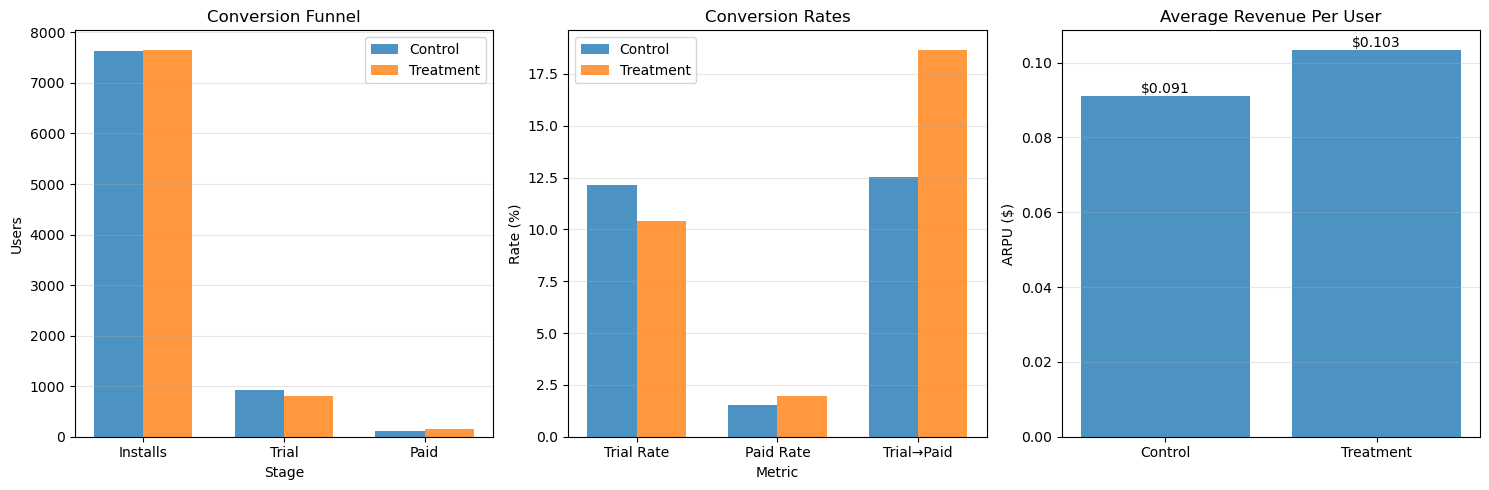

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = np.arange(3)
width = 0.35

# Funnel
funnel = pd.DataFrame({
    'Stage': ['Installs', 'Trial', 'Paid'],
    'Control': [trial_metrics.loc['control', 'total_users'], trial_metrics.loc['control', 'trial_users'], paid_metrics.loc['control', 'paid_users']],
    'Treatment': [trial_metrics.loc['treatment', 'total_users'], trial_metrics.loc['treatment', 'trial_users'], paid_metrics.loc['treatment', 'paid_users']]
})
axes[0].bar(x - width/2, funnel['Control'], width, label='Control', alpha=0.8)
axes[0].bar(x + width/2, funnel['Treatment'], width, label='Treatment', alpha=0.8)
axes[0].set(xlabel='Stage', ylabel='Users', title='Conversion Funnel', xticks=x, xticklabels=funnel['Stage'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Rates
rates = pd.DataFrame({
    'Control': [control_trial_rate*100, control_paid_rate*100, control_t2p*100],
    'Treatment': [treatment_trial_rate*100, treatment_paid_rate*100, treatment_t2p*100]
}, index=['Trial Rate', 'Paid Rate', 'Trial→Paid'])
axes[1].bar(x - width/2, rates['Control'], width, label='Control', alpha=0.8)
axes[1].bar(x + width/2, rates['Treatment'], width, label='Treatment', alpha=0.8)
axes[1].set(xlabel='Metric', ylabel='Rate (%)', title='Conversion Rates', xticks=x, xticklabels=rates.index)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# ARPU
arpu_vals = [control_arpu, treatment_arpu]
bars = axes[2].bar(['Control', 'Treatment'], arpu_vals, alpha=0.8)
axes[2].set(ylabel='ARPU ($)', title='Average Revenue Per User')
axes[2].grid(axis='y', alpha=0.3)
for bar in bars:
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${bar.get_height():.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:
# Statistical significance tests

from scipy.stats import chi2_contingency, mannwhitneyu

# Trial rate
contingency_trial = pd.crosstab(df['test_group'], df['trial'])
chi2_trial, p_trial, _, _ = chi2_contingency(contingency_trial)

# Paid rate
contingency_paid = pd.crosstab(df['test_group'], df['paid'])
chi2_paid, p_paid, _, _ = chi2_contingency(contingency_paid)

# Trial-to-Paid
trial_users = df[df['trial'] == 1]
contingency_t2p = pd.crosstab(trial_users['test_group'], trial_users['paid'])
chi2_t2p, p_t2p, _, _ = chi2_contingency(contingency_t2p)

# Revenue 
control_rev = df[df['test_group'] == 'control']['revenue_1m'] 
treatment_rev = df[df['test_group'] == 'treatment']['revenue_1m'] 
u_stat, p_revenue = mannwhitneyu(control_rev, treatment_rev, alternative='two-sided') 

results_df = pd.DataFrame({
    'Metric': ['Trial Rate', 'Paid Rate', 'Trial to Paid', 'Revenue'],
    'P-value': [p_trial, p_paid, p_t2p, p_revenue]
})

display(results_df)

,Metric,P-value
0,Trial Rate,0.000927
1,Paid Rate,0.051211
2,Trial to Paid,0.000559
3,Revenue,0.053413


 **Статистична значущість:**

**Достовірні ефекти:**
- Trial Rate: зниження на 14% є статистично значущим. 
- Trial-to-Paid Conversion: зростання на 49% статистично значуще. Treatment реально покращує конверсію серед trial користувачів.

**Недостовірні ефекти:**
- Paid Rate: зростання на 28% знаходиться на межі значущості. При p = 5.1% ми не можемо з упевненістю сказати, що різниця не випадкова.
- Revenue: зростання ARPU на 14% також на межі.

Причина: всього 265 paying users з 15,285, а це менше 2%. Для revenue-метрик тесту просто не вистачає даних.

**Рекомендації:**
1. Продовжити тест на 2-4 тижні для збільшення sample size paying users. Paid rate та revenue дуже близькі до порогу значущості і додатковий обсяг з високою ймовірністю підтвердить або спростує ефект.
2. Довіряти достовірним результатам: зниження trial rate (-14%) та зростання trial-to-paid (+49%) є реальними ефектами
3. Подовжити спостереження до 2-3 місяців, щоб зрозуміти довгостроковий retention тижневої підписки.

In [14]:
# Сountry-level breakdown

country_metrics = df.groupby(['country', 'test_group']).apply(
    lambda x: pd.Series({
        'sample_size': len(x),
        'trial_rate': round(x['trial'].mean() * 100, 2),
        'trial_to_paid': round(x[x['trial'] == 1]['paid'].mean() * 100, 2) if (x['trial'] == 1).sum() > 0 else 0,
        'paid_rate': round(x['paid'].mean() * 100, 2),
        'arpu': round(x['revenue_1m'].mean(), 3)
    })
).reset_index()

display(country_metrics)

# Lifts by country
lifts = []
for country in ['AU', 'CA', 'GB', 'US']:
    control = country_metrics[(country_metrics['country'] == country) & (country_metrics['test_group'] == 'control')].iloc[0]
    treatment = country_metrics[(country_metrics['country'] == country) & (country_metrics['test_group'] == 'treatment')].iloc[0]
    
    lifts.append({
        'Country': country,
        'Trial Rate Lift': f"{((treatment['trial_rate'] - control['trial_rate']) / control['trial_rate'] * 100):+.2f}%",
        'Trial-to-Paid Lift': f"{((treatment['trial_to_paid'] - control['trial_to_paid']) / control['trial_to_paid'] * 100):+.2f}%",
        'Paid Rate Lift': f"{((treatment['paid_rate'] - control['paid_rate']) / control['paid_rate'] * 100):+.2f}%",
        'ARPU Lift': f"{((treatment['arpu'] - control['arpu']) / control['arpu'] * 100):+.2f}%"
    })

lifts_df = pd.DataFrame(lifts)
display(lifts_df)

,country,test_group,sample_size,trial_rate,trial_to_paid,paid_rate,arpu
0,AU,control,1928.0,11.83,13.16,1.56,0.093
1,AU,treatment,1835.0,10.41,20.42,2.13,0.114
2,CA,control,1936.0,11.31,8.22,0.93,0.056
3,CA,treatment,1959.0,10.62,17.79,1.89,0.095
4,GB,control,1846.0,14.63,12.96,1.90,0.114
5,GB,treatment,1991.0,10.50,19.62,2.06,0.111
6,US,control,1917.0,10.85,15.87,1.72,0.103
7,US,treatment,1873.0,10.14,16.84,1.71,0.094


,Country,Trial Rate Lift,Trial-to-Paid Lift,Paid Rate Lift,ARPU Lift
0,AU,-12.00%,+55.17%,+36.54%,+22.58%
1,CA,-6.10%,+116.42%,+103.23%,+69.64%
2,GB,-28.23%,+51.39%,+8.42%,-2.63%
3,US,-6.54%,+6.11%,-0.58%,-8.74%


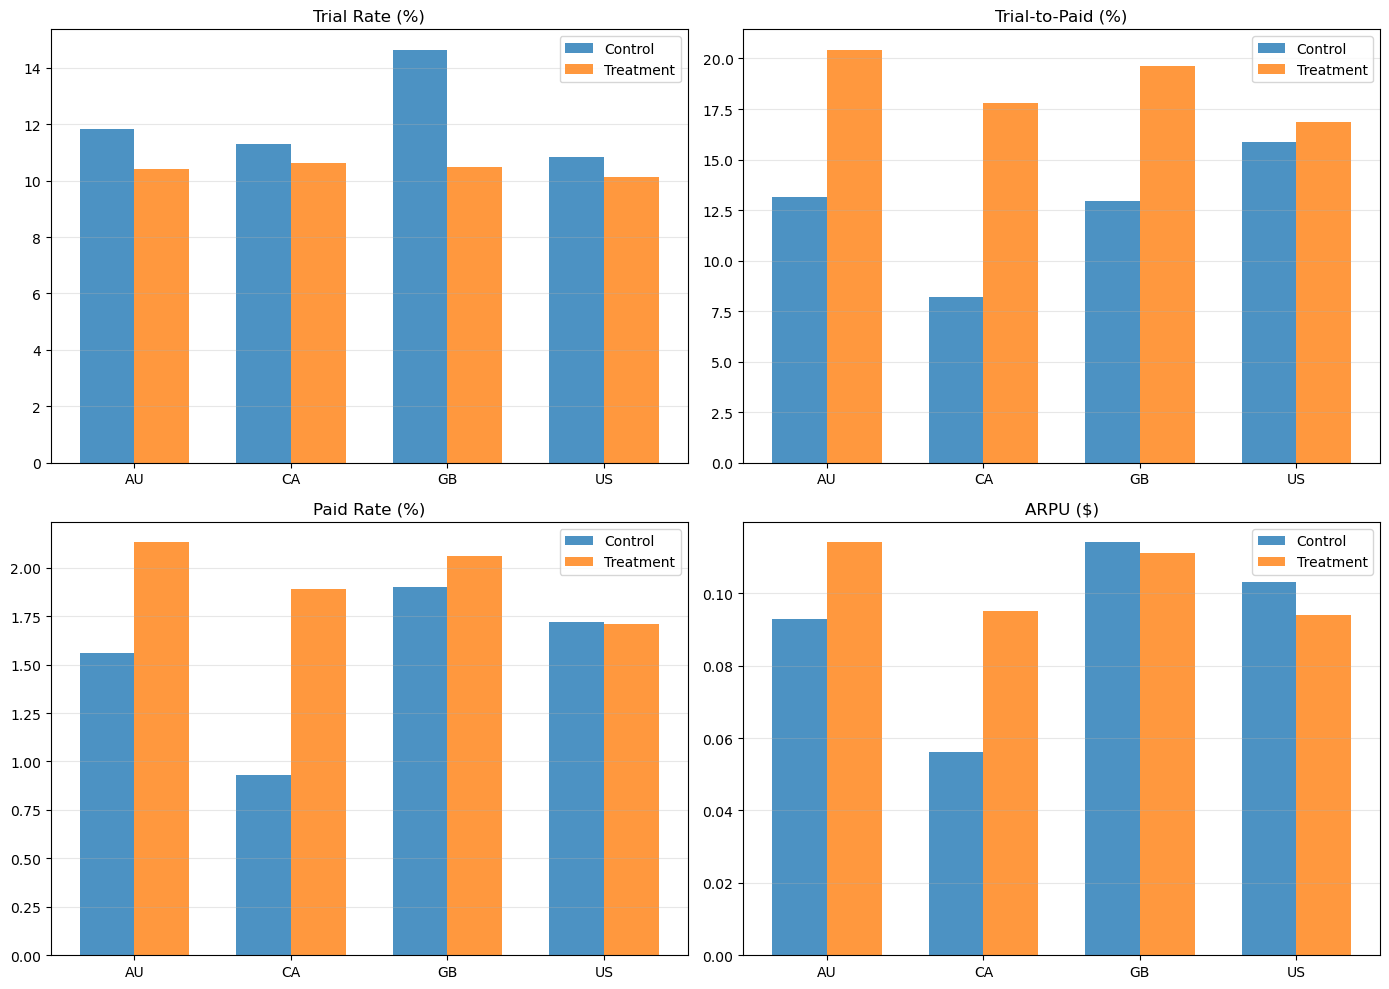

In [15]:
# Country visualization
countries = ['AU', 'CA', 'GB', 'US']
x = np.arange(len(countries))
width = 0.35

metrics_to_plot = [
    ('trial_rate', 'Trial Rate (%)'),
    ('trial_to_paid', 'Trial-to-Paid (%)'),
    ('paid_rate', 'Paid Rate (%)'),
    ('arpu', 'ARPU ($)'),
]

plt.figure(figsize=(14, 10))
for i, (col, title) in enumerate(metrics_to_plot):
    ctrl = country_metrics[country_metrics['test_group'] == 'control'][col].values
    treat = country_metrics[country_metrics['test_group'] == 'treatment'][col].values
    
    plt.subplot(2, 2, i + 1)
    plt.bar(x - width/2, ctrl, width, label='Control', alpha=0.8)
    plt.bar(x + width/2, treat, width, label='Treatment', alpha=0.8)
    plt.title(title)
    plt.xticks(x, countries)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

По країнах ефект дуже різний:

**Де працює:**
- Canada: +70% ARPU, +116% trial-to-paid, trial rate впав мінімально (-6%). Найкращий результат
- Australia: +23% ARPU, +56% trial-to-paid — стабільне зростання

**Де не працює:**
- UK: ARPU -3%. Trial rate впав на 28% і це зʼїло весь плюс від конверсії (+51%)
- US: ARPU -9%. Trial-to-paid виріс лише на 6%, майже без ефекту

Всі країни показують зростання trial-to-paid, але в US/GB це не компенсує падіння trial rate. Загальний позитивний результат тесту тримається на CA і AU, тому якщо планується глобальний rollout, для US та GB потрібна інша стратегія.

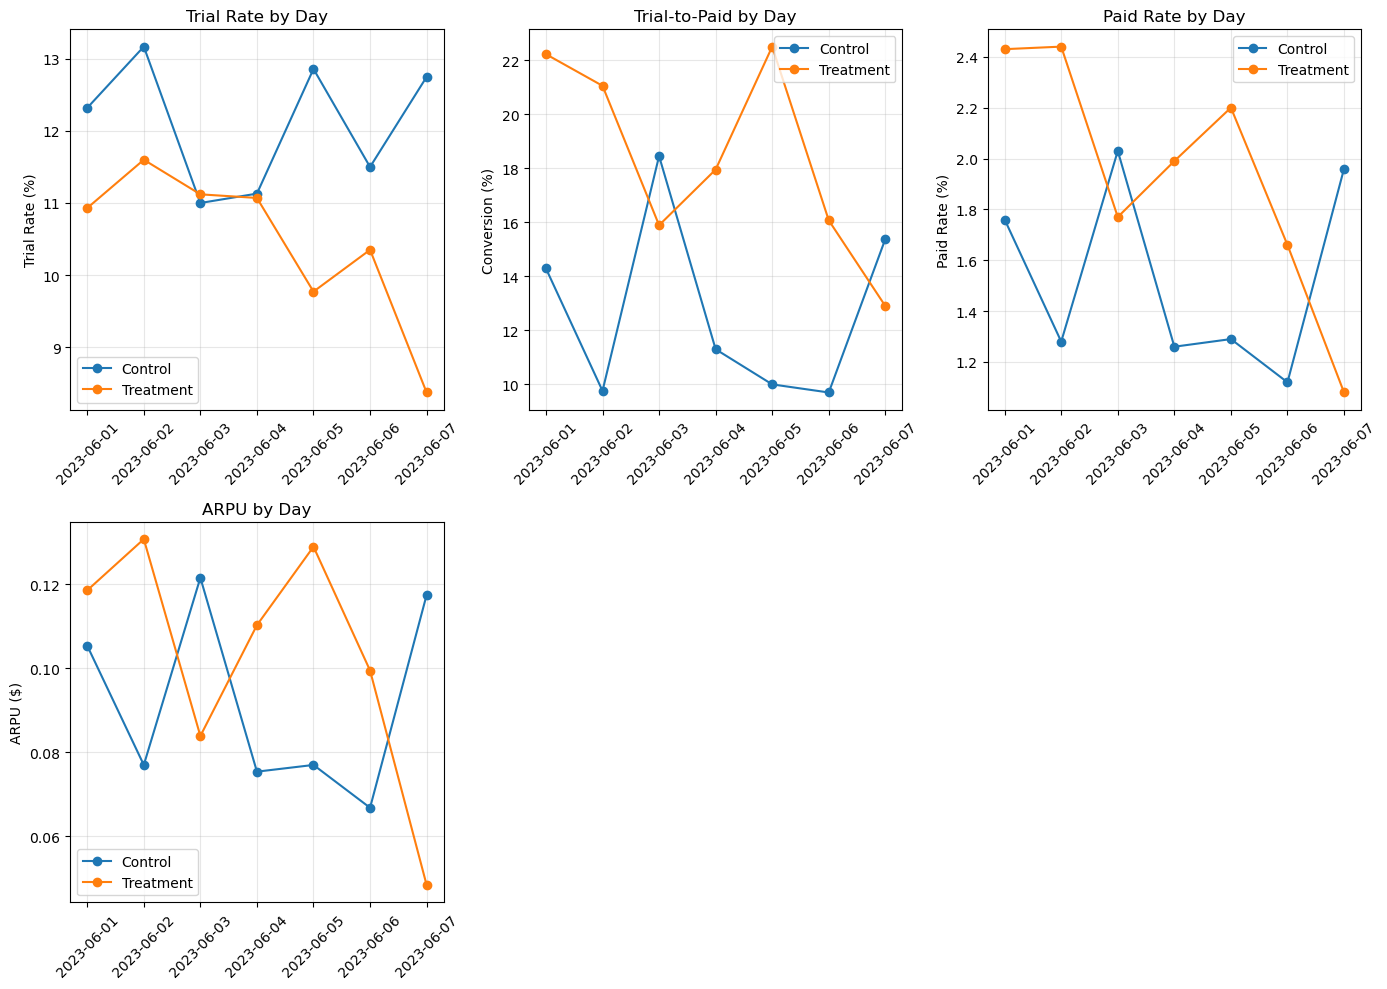

In [16]:
# Install date analysis 

daily_metrics = df.groupby(['install_date', 'test_group']).apply(
    lambda x: pd.Series({
        'user_count': len(x),
        'trial_rate': round(x['trial'].mean() * 100, 2),
        'trial_to_paid': round(x[x['trial'] == 1]['paid'].mean() * 100, 2) if (x['trial'] == 1).sum() > 0 else 0,
        'paid_rate': round(x['paid'].mean() * 100, 2),
        'arpu': round(x['revenue_1m'].mean(), 4)
    })
).reset_index()

# Visualization: Daily trends
plt.figure(figsize=(14, 10))

for group in ['control', 'treatment']:
    group_data = daily_metrics[daily_metrics['test_group'] == group]
    
    plt.subplot(2, 3, 1)
    plt.plot(group_data['install_date'], group_data['trial_rate'], marker='o', label=group.capitalize())
    
    plt.subplot(2, 3, 2)
    plt.plot(group_data['install_date'], group_data['trial_to_paid'], marker='o', label=group.capitalize())
    
    plt.subplot(2, 3, 3)
    plt.plot(group_data['install_date'], group_data['paid_rate'], marker='o', label=group.capitalize())
    
    plt.subplot(2, 3, 4)
    plt.plot(group_data['install_date'], group_data['arpu'], marker='o', label=group.capitalize())

plt.subplot(2, 3, 1)
plt.title('Trial Rate by Day')
plt.ylabel('Trial Rate (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 3, 2)
plt.title('Trial-to-Paid by Day')
plt.ylabel('Conversion (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
plt.title('Paid Rate by Day')
plt.ylabel('Paid Rate (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
plt.title('ARPU by Day')
plt.ylabel('ARPU ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

За період тесту (7 днів) не спостерігається аномалій або систематичних трендів. Проте тижневий період недостатній для висновків про day-of-week ефекти.

## Загальний висновок

**Treatment (тижнева підписка $2.99) показує змішані результати:**

**Позитивне:**
- Trial-to-paid конверсія значно вища (+49%)
- Більше paying users (149 vs 116)
- Позитивний тренд в ARPU (+13.6%) та total revenue (+14%)

**Ризики:**
- Trial rate нижчий (-14%) — менше юзерів починають trial
- 50% paying users відписуються після першого тижня
- Ефект на US та GB ринках негативний (-9% та -3% ARPU)
- Revenue-ефект не підтверджений статистично (p=0.053)

**Рекомендація:** не розкочувати treatment глобально. Продовжити тест (більше юзерів + довший період спостереження) та розглянути сегментований підхід: rollout для CA/AU, окрема цінова стратегія для US/GB.